In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv(r'/home/saswata/data_science/UM_projects/world_population/world_population.csv')
df

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,226,WLF,Wallis and Futuna,Mata-Utu,Oceania,11572,11655,12182,13142,14723,13454,11315,9377,142,81.4930,0.9953,0.00
230,172,ESH,Western Sahara,El Aaiún,Africa,575986,556048,491824,413296,270375,178529,116775,76371,266000,2.1654,1.0184,0.01
231,46,YEM,Yemen,Sanaa,Asia,33696614,32284046,28516545,24743946,18628700,13375121,9204938,6843607,527968,63.8232,1.0217,0.42
232,63,ZMB,Zambia,Lusaka,Africa,20017675,18927715,16248230,13792086,9891136,7686401,5720438,4281671,752612,26.5976,1.0280,0.25


In [3]:
import pandas as pd
import statsmodels.api as sm

# --- Melt the Data ---
pop_cols = [col for col in df.columns if 'Population' in col and 'World' not in col]
df_melted = df.melt(
    id_vars=['Country/Territory', 'Area (km²)', 'Growth Rate'],
    value_vars=pop_cols,
    var_name='Year',
    value_name='Population'
)
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d{4})').astype(int)
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-01-01')  # Set date as 1st Jan of each year
df_melted.sort_values(by=['Country/Territory', 'Date'], inplace=True)

# --- Feature Engineering ---
df_melted['Density'] = df_melted['Population'] / df_melted['Area (km²)']

# Initialize Growth and Growth Rate Δ with NaN
df_melted['Growth'] = pd.NA

# Set Growth and Growth Rate Δ for the first year (1970) as 0
df_melted.loc[df_melted['Year'] == 1970, 'Growth'] = 0

# Calculate Growth and Growth Rate Δ, starting from 1971 (second year)
for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].sort_values(by='Year').copy()
    
    # Calculate Growth (change in population relative to previous year) and Growth Rate Δ (difference of Growth)
    for i in range(1, len(country_df)):
        current_year = country_df.iloc[i]
        previous_year = country_df.iloc[i-1]
        
        # Calculate Growth Rate (change in population from previous year to current year)
        growth_rate = (current_year['Population'] - previous_year['Population']) / previous_year['Population']
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == current_year['Year']), 'Growth'] = growth_rate
        


# --- Extrapolation for 1970 ---
# After calculating growth for subsequent years, we can extrapolate growth for the first year.
# We'll simply carry forward the second year’s growth and growth rate change to the first year.

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()
    
    # Extrapolate growth and rate of change of growth rate from second year to the first year
    if 1971 in country_df['Year'].values:
        growth_2nd_year = country_df[country_df['Year'] == 1971]['Growth'].values[0]
        
        # Extrapolate using 2nd year's values for the first year
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == 1970), 'Growth'] = growth_2nd_year

df_melted = df_melted.drop(['Growth Rate'], axis=1)
df_melted.head(20)

,Country/Territory,Area (km²),Year,Population,Date,Density,Growth
1638,Afghanistan,652230,1970,10752971,1970-01-01,16.486471,0
1404,Afghanistan,652230,1980,12486631,1980-01-01,19.144521,0.161226
1170,Afghanistan,652230,1990,10694796,1990-01-01,16.397277,-0.1435
936,Afghanistan,652230,2000,19542982,2000-01-01,29.963329,0.827336
702,Afghanistan,652230,2010,28189672,2010-01-01,43.220447,0.442445
468,Afghanistan,652230,2015,33753499,2015-01-01,51.750915,0.197371
234,Afghanistan,652230,2020,38972230,2020-01-01,59.752281,0.154613
0,Afghanistan,652230,2022,41128771,2022-01-01,63.058692,0.055335
1639,Albania,28748,1970,2324731,1970-01-01,80.865834,0
1405,Albania,28748,1980,2941651,1980-01-01,102.325414,0.265373


In [4]:
all_years = pd.DataFrame({'Year': range(1970, 2023)})
interpolated_dfs = []

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()

    merged = pd.merge(all_years, country_df, on='Year', how='left')
    merged['Country/Territory'] = country
    merged['Area (km²)'] = merged['Area (km²)'].ffill()

    # Interpolate population
    merged['Population'] = merged['Population'].interpolate(method='linear')

    # Recompute Date and Density
    merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + '-01-01')
    merged['Density'] = merged['Population'] / merged['Area (km²)']

    # Recompute Growth as % change
    merged['Growth'] = merged['Population'].pct_change()
    merged.loc[0, 'Growth'] = merged.loc[1, 'Growth']  # Extrapolate first year

    interpolated_dfs.append(merged)

df_full = pd.concat(interpolated_dfs, ignore_index=True)
df_full.sort_values(by=['Country/Territory', 'Year'], inplace=True)

df_full

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,1970,Afghanistan,652230.0,10752971.0,1970-01-01,16.486471,0.016123
1,1971,Afghanistan,652230.0,10926337.0,1971-01-01,16.752276,0.016123
2,1972,Afghanistan,652230.0,11099703.0,1972-01-01,17.018081,0.015867
3,1973,Afghanistan,652230.0,11273069.0,1973-01-01,17.283886,0.015619
4,1974,Afghanistan,652230.0,11446435.0,1974-01-01,17.549691,0.015379
...,...,...,...,...,...,...,...
12397,2018,Zimbabwe,390757.0,15063774.4,2018-01-01,38.550236,0.020524
12398,2019,Zimbabwe,390757.0,15366720.2,2019-01-01,39.325515,0.020111
12399,2020,Zimbabwe,390757.0,15669666.0,2020-01-01,40.100794,0.019714
12400,2021,Zimbabwe,390757.0,15995101.5,2021-01-01,40.933628,0.020769


In [5]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Grouped ARIMA Forecast Function
def forecast_arima(series, steps=10, seasonal=False, m=1):
    # Drop NaNs
    series = series.dropna()
    
    # Stationarity check
    adf_pval = adfuller(series)[1]
    d = 0 if adf_pval < 0.05 else 1

    # Auto ARIMA to choose p, d, q
    model = auto_arima(series, seasonal=seasonal, m=m, d=d, trace=False, suppress_warnings=True)
    
    # Forecast
    forecast = model.predict(n_periods=steps)
    return forecast, model

# Storage
forecast_results = {}

# Loop through countries
for country in df_full['Country/Territory'].unique():
    country_df = df_full[df_full['Country/Territory'] == country].sort_values('Year')
    
    growth_series = country_df.set_index('Year')['Growth'].astype(float)

    # Predict next 5 years of Growth
    growth_forecast, growth_model = forecast_arima(growth_series, steps=10)
    

    forecast_results[country] = {
        'growth_forecast': growth_forecast,
        'growth_model': growth_model,
    }

forecast_df = []

for country, data in forecast_results.items():
    last_row = df_full[df_full['Country/Territory'] == country].sort_values('Year').iloc[-1]
    last_year = int(last_row['Year'])
    area = last_row['Area (km²)']
    population = last_row['Population']
    
    for i, growth in enumerate(data['growth_forecast'], 1):
        year = last_year + i
        population = population * (1 + growth)
        density = population / area

        forecast_df.append({
            'Year': year,
            'Country/Territory': country,
            'Area (km²)': area,
            'Population': population,
            'Date': pd.to_datetime(f'{year}-01-01'),
            'Density': density,
            'Growth': growth
        })

forecast_df = pd.DataFrame(forecast_df)

forecast_df

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,2023,Afghanistan,652230.0,4.223607e+07,2023-01-01,64.756407,0.026923
1,2024,Afghanistan,652230.0,4.337318e+07,2024-01-01,66.499829,0.026923
2,2025,Afghanistan,652230.0,4.454091e+07,2025-01-01,68.290189,0.026923
3,2026,Afghanistan,652230.0,4.574007e+07,2026-01-01,70.128750,0.026923
4,2027,Afghanistan,652230.0,4.697152e+07,2027-01-01,72.016811,0.026923
...,...,...,...,...,...,...,...
2335,2028,Zimbabwe,390757.0,1.841701e+07,2028-01-01,47.131617,0.020346
2336,2029,Zimbabwe,390757.0,1.879172e+07,2029-01-01,48.090555,0.020346
2337,2030,Zimbabwe,390757.0,1.917406e+07,2030-01-01,49.069003,0.020346
2338,2031,Zimbabwe,390757.0,1.956417e+07,2031-01-01,50.067358,0.020346


In [6]:
forecast_df[:20]

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,2023,Afghanistan,652230.0,4.223607e+07,2023-01-01,64.756407,0.026923
1,2024,Afghanistan,652230.0,4.337318e+07,2024-01-01,66.499829,0.026923
2,2025,Afghanistan,652230.0,4.454091e+07,2025-01-01,68.290189,0.026923
3,2026,Afghanistan,652230.0,4.574007e+07,2026-01-01,70.128750,0.026923
4,2027,Afghanistan,652230.0,4.697152e+07,2027-01-01,72.016811,0.026923
5,2028,Afghanistan,652230.0,4.823613e+07,2028-01-01,73.955703,0.026923
6,2029,Afghanistan,652230.0,4.953478e+07,2029-01-01,75.946795,0.026923
7,2030,Afghanistan,652230.0,5.086839e+07,2030-01-01,77.991494,0.026923
8,2031,Afghanistan,652230.0,5.223791e+07,2031-01-01,80.091241,0.026923
9,2032,Afghanistan,652230.0,5.364430e+07,2032-01-01,82.247519,0.026923


In [7]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode countries from df_full
le = LabelEncoder()
df_full['Encoded_Country'] = le.fit_transform(df_full['Country/Territory'])
label_to_country = dict(zip(le.transform(le.classes_), le.classes_))
country_to_label = dict(zip(le.classes_, le.transform(le.classes_)))

# Encode country in forecast_df
forecast_df['Country'] = forecast_df['Country/Territory'].map(country_to_label)
forecast_df.rename(columns={'Growth': 'Predicted_Growth'}, inplace=True)

# Drop unused columns from df_full
x_temp = df_full.drop(['Growth', 'Date'], axis=1)
x_copy_sorted = x_temp.sort_values(by=['Country/Territory', 'Year'])

# Decode country for merging
forecast_df['Decoded_Country'] = forecast_df['Country'].map(label_to_country)

# Build final combined DataFrame
all_countries_data = []

for country in forecast_df['Decoded_Country'].unique():
    # Historical data
    past_data = x_copy_sorted[x_copy_sorted['Country/Territory'] == country].copy()
    past_data = past_data.sort_values(by='Year')
    growth_data = df_full[df_full['Country/Territory'] == country][['Year', 'Growth']]
    past_data = past_data.merge(growth_data, on='Year', how='left')

    # Predicted data
    preds_df = forecast_df[forecast_df['Decoded_Country'] == country].copy()
    preds_df = preds_df[['Decoded_Country', 'Area (km²)', 'Year', 'Population', 'Density', 'Predicted_Growth']]
    preds_df.rename(columns={
        'Decoded_Country': 'Country/Territory',
        'Predicted_Growth': 'Growth'
    }, inplace=True)

    # Combine
    combined_df = pd.concat([past_data, preds_df], ignore_index=True)
    all_countries_data.append(combined_df)

# Final ARIMA combined DataFrame
arima_combined_df = pd.concat(all_countries_data, ignore_index=True)
arima_combined_df.drop('Encoded_Country', axis=1, inplace=True)
print(arima_combined_df.head())


   Year Country/Territory  Area (km²)  Population    Density    Growth
0  1970       Afghanistan    652230.0  10752971.0  16.486471  0.016123
1  1971       Afghanistan    652230.0  10926337.0  16.752276  0.016123
2  1972       Afghanistan    652230.0  11099703.0  17.018081  0.015867
3  1973       Afghanistan    652230.0  11273069.0  17.283886  0.015619
4  1974       Afghanistan    652230.0  11446435.0  17.549691  0.015379


In [8]:
arima_combined_df.iloc[40:70]

,Year,Country/Territory,Area (km²),Population,Density,Growth
40,2010,Afghanistan,652230.0,2.818967e+07,43.220447,0.031644
41,2011,Afghanistan,652230.0,2.930244e+07,44.926540,0.039474
42,2012,Afghanistan,652230.0,3.041520e+07,46.632634,0.037975
43,2013,Afghanistan,652230.0,3.152797e+07,48.338727,0.036586
44,2014,Afghanistan,652230.0,3.264073e+07,50.044821,0.035295
45,2015,Afghanistan,652230.0,3.375350e+07,51.750915,0.034091
46,2016,Afghanistan,652230.0,3.479725e+07,53.351188,0.030923
47,2017,Afghanistan,652230.0,3.584099e+07,54.951461,0.029995
48,2018,Afghanistan,652230.0,3.688474e+07,56.551734,0.029122
49,2019,Afghanistan,652230.0,3.792848e+07,58.152007,0.028298


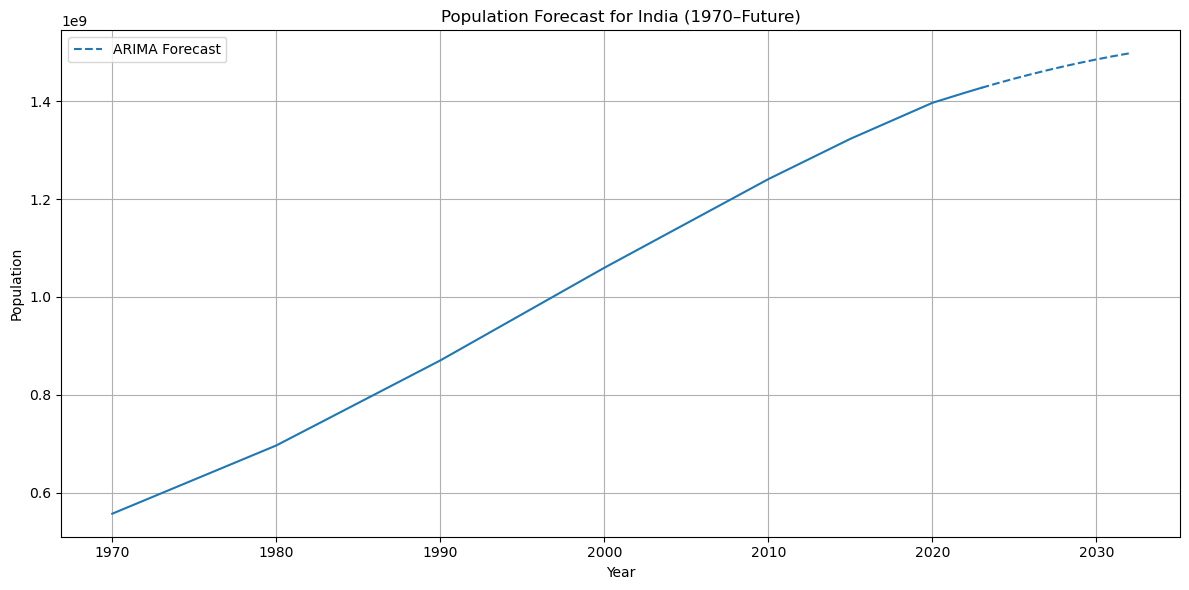

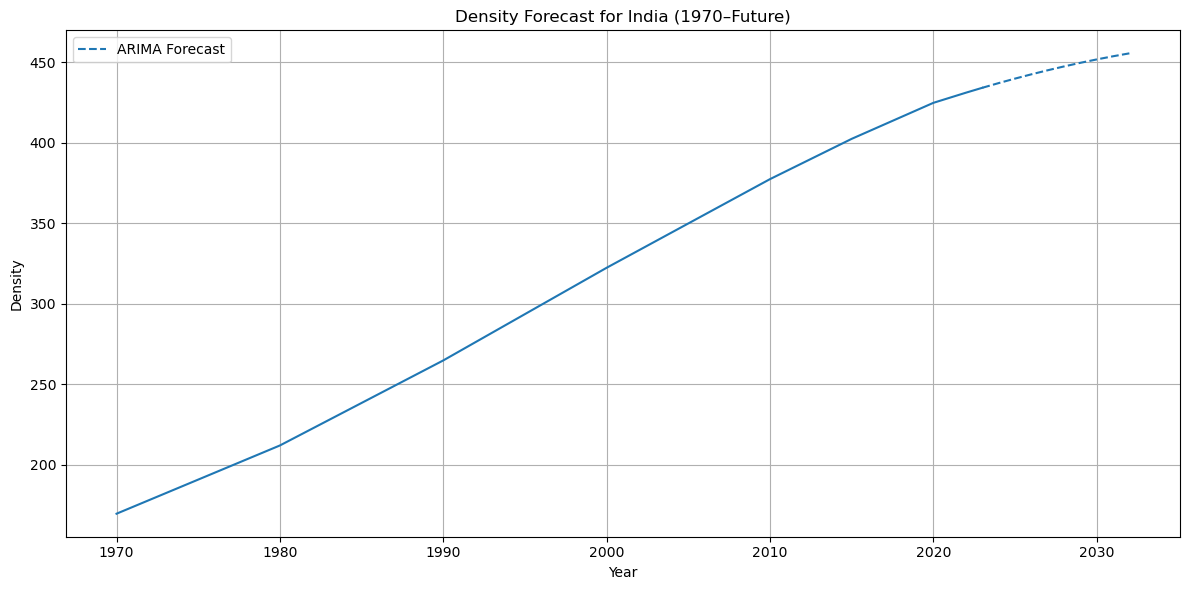

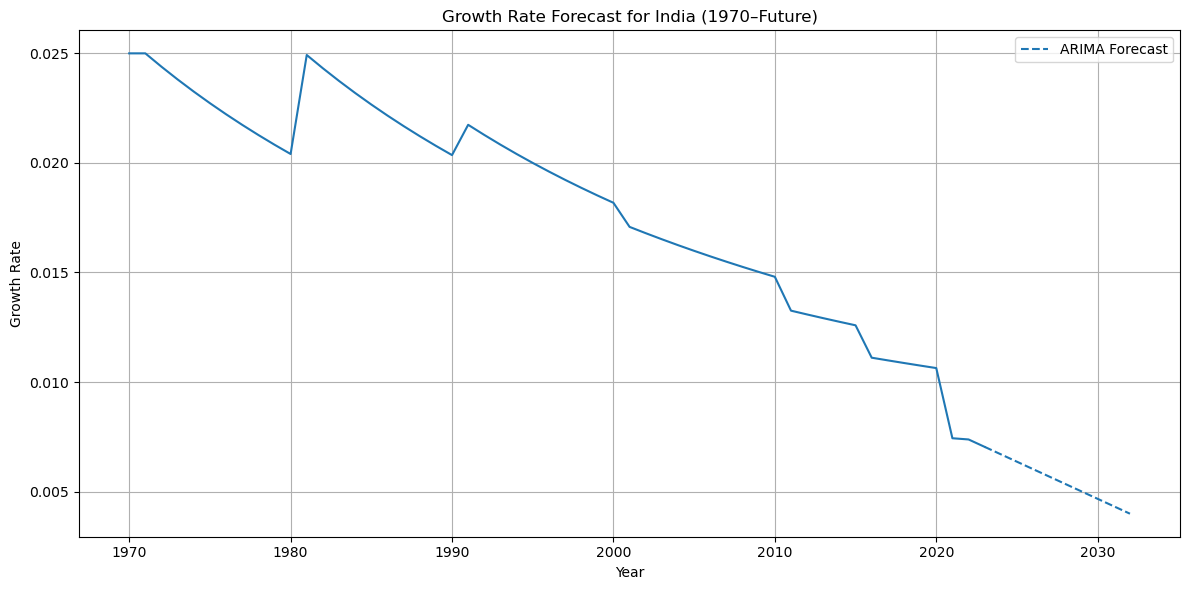

In [9]:
import matplotlib.pyplot as plt

split_year = 2023
start_year = 1970
country = 'India'

df_india = arima_combined_df[arima_combined_df['Country/Territory'] == country].sort_values('Year')
df_india = df_india[df_india['Year'] >= start_year]

# Plot config function
def plot_feature(feature, ylabel):
    plt.figure(figsize=(12, 6))
    df_hist = df_india[df_india['Year'] <= split_year]
    df_pred = df_india[df_india['Year'] >= split_year]

    if not df_hist.empty:
        line, = plt.plot(df_hist['Year'], df_hist[feature], linestyle='-')
    if not df_pred.empty:
        plt.plot(df_pred['Year'], df_pred[feature], linestyle='--', color=line.get_color(), label='ARIMA Forecast')

    plt.title(f"{ylabel} Forecast for {country} ({start_year}–Future)")
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plots
plot_feature('Population', 'Population')
plot_feature('Density', 'Density')
plot_feature('Growth', 'Growth Rate')


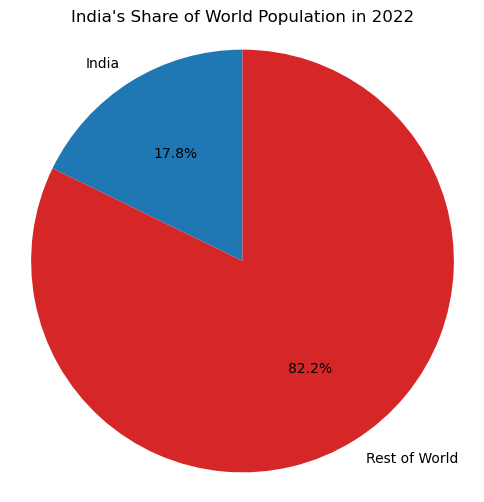

In [12]:
import matplotlib.pyplot as plt

# Get the last year in historical data
end_year_hist = df_full['Year'].max()

# Total world population in that year
world_pop_hist = df_full[df_full['Year'] == end_year_hist]['Population'].sum()

# India's population in that year
india_pop_hist = df_full[(df_full['Country/Territory'] == 'India') & (df_full['Year'] == end_year_hist)]['Population'].values[0]

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie([india_pop_hist, world_pop_hist - india_pop_hist],
        labels=['India', 'Rest of World'],
        autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#d62728'])
plt.title(f"India's Share of World Population in {end_year_hist}")
plt.axis('equal')
plt.show()


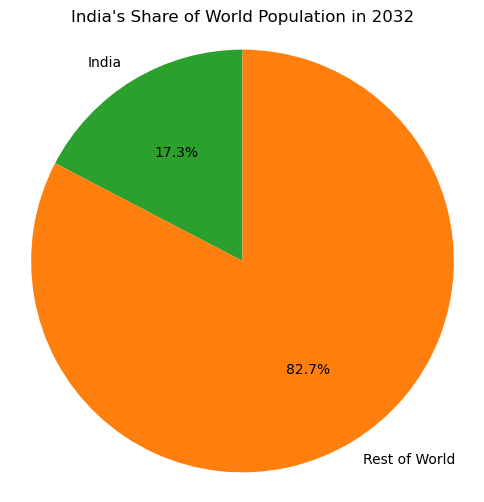

In [13]:
# Get the last year in forecast
end_year_forecast = forecast_df['Year'].max()

# Total forecasted world population in that year
world_pop_forecast = forecast_df[forecast_df['Year'] == end_year_forecast]['Population'].sum()

# India's forecasted population
india_pop_forecast = forecast_df[(forecast_df['Country/Territory'] == 'India') & (forecast_df['Year'] == end_year_forecast)]['Population'].values[0]

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie([india_pop_forecast, world_pop_forecast - india_pop_forecast],
        labels=['India', 'Rest of World'],
        autopct='%1.1f%%', startangle=90, colors=['#2ca02c', '#ff7f0e'])
plt.title(f"India's Share of World Population in {end_year_forecast}")
plt.axis('equal')
plt.show()


In [11]:
import joblib
import os

os.makedirs("saved_models/arima", exist_ok=True)

for country, data in forecast_results.items():
    model = data['growth_model']
    filename = f"saved_models/arima/arima_model_{country.replace('/', '_')}.pkl"
    joblib.dump(model, filename)
